In [1]:
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import Input, optimizers
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np

base_dir = "Splitted_70-30"
test_dir = "test_img"
BATCH_SIZE = 32
IMAGE_SIZE = 224

datagen = ImageDataGenerator(
     preprocessing_function= preprocess_input,
     rotation_range=50,
     width_shift_range=0.3,
     height_shift_range=0.3,
     zoom_range = .2,
     horizontal_flip=True,
     shear_range=0.2
    )

traingen = datagen.flow_from_directory(base_dir + "/train", 
target_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE,
class_mode="categorical")
# save_to_dir= "test_img",
# save_prefix="Test")

valgen = datagen.flow_from_directory(base_dir + "/val", 
target_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE,
class_mode="categorical")

# testgen = datagen.flow_from_directory(test_dir + "/test", 
# target_size=(IMAGE_SIZE,IMAGE_SIZE),
# batch_size=1,
# class_mode="categorical")

Found 1050 images belonging to 3 classes.
Found 450 images belonging to 3 classes.


In [2]:
print(traingen.class_indices)
print(valgen.class_indices)
# print(testgen.class_indices)

{'debrisflow': 0, 'earthflow': 1, 'rockfall': 2}
{'debrisflow': 0, 'earthflow': 1, 'rockfall': 2}


In [3]:
with tf.device('/device:GPU:0'):
  model = Sequential()

  model.add(ResNet50(include_top=False, weights='imagenet',input_tensor=Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))))
  model.add(GlobalAveragePooling2D())

  model.add(Dense(3))
  model.add(Activation('softmax'))

  model.layers[0].trainable = False

  
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  history = model.fit(traingen, validation_data=valgen, epochs=30)

  # model.save('Saved_Model/ResNet70-30_50epochs.h5')

Epoch 1/30
33/33 [==============================] - 54s 2s/step - loss: 0.9757 - accuracy: 0.5448 - val_loss: 0.8135 - val_accuracy: 0.6467
Epoch 2/30
33/33 [==============================] - 50s 2s/step - loss: 0.6759 - accuracy: 0.6952 - val_loss: 0.6570 - val_accuracy: 0.7267
Epoch 3/30
33/33 [==============================] - 50s 2s/step - loss: 0.6001 - accuracy: 0.7467 - val_loss: 0.6981 - val_accuracy: 0.6733
Epoch 4/30
33/33 [==============================] - 50s 2s/step - loss: 0.5122 - accuracy: 0.7981 - val_loss: 0.5268 - val_accuracy: 0.7844
Epoch 5/30
33/33 [==============================] - 51s 2s/step - loss: 0.4579 - accuracy: 0.8295 - val_loss: 0.4960 - val_accuracy: 0.8022
Epoch 6/30
33/33 [==============================] - 51s 2s/step - loss: 0.4454 - accuracy: 0.8190 - val_loss: 0.4834 - val_accuracy: 0.8356
Epoch 7/30
33/33 [==============================] - 51s 2s/step - loss: 0.4058 - accuracy: 0.8457 - val_loss: 0.4454 - val_accuracy: 0.8289
Epoch 8/30
33/33 [==

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
 activation (Activation)     (None, 3)                 0         
                                                                 
Total params: 23,593,859
Trainable params: 6,147
Non-trainable params: 23,587,712
_________________________________________________________________


Text(0.5, 1.0, 'LOSS')

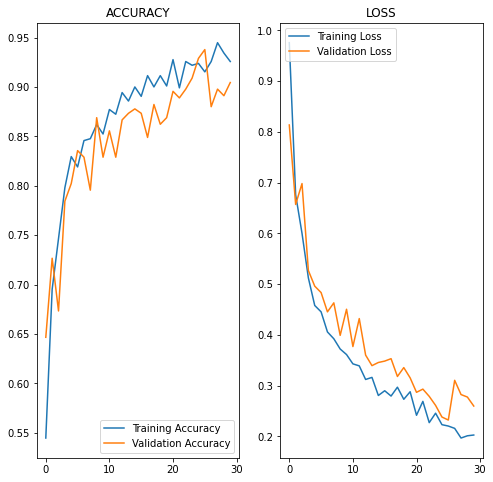

In [5]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('ACCURACY')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('LOSS')

# plt.savefig('Splitted')

In [6]:
train_predictions = np.argmax(model.predict(traingen), axis=1)
class_predictions = np.argmax(model.predict(valgen), axis=1)

In [7]:
print("Loss of the model is - " , model.evaluate(valgen)[0])
print("Accuracy of the model is - " , model.evaluate(valgen)[1]*100 , "%")

15/15 [==============================] - 15s 1s/step - loss: 0.2312 - accuracy: 0.9156
Loss of the model is -  0.23118945956230164
15/15 [==============================] - 15s 1s/step - loss: 0.2099 - accuracy: 0.9267
Accuracy of the model is -  92.66666769981384 %


              precision    recall  f1-score   support

           0       0.35      0.35      0.35       150
           1       0.28      0.27      0.27       150
           2       0.35      0.35      0.35       150

    accuracy                           0.32       450
   macro avg       0.32      0.32      0.32       450
weighted avg       0.32      0.32      0.32       450



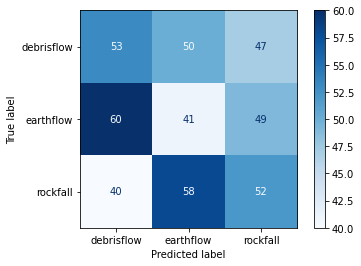

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

labels = ["debrisflow", "earthflow", "rockfall"]

print(classification_report(valgen.labels,class_predictions))

cm = confusion_matrix(valgen.labels,class_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()